# Ch7 ISLR: Applied 1

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import Pipeline

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

np.set_printoptions(precision=4)

## Import Data

In [2]:
Wages = pd.read_csv('../../../data/Wage.csv')
Wages.head(3)

,Unnamed: 0,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177


## Polynomial Regression of Age onto Wage

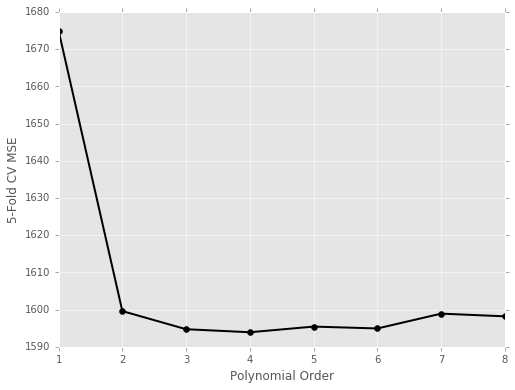

In [3]:
scores = np.array([])
orders = np.arange(1,9)

for order in orders:
    # make a polynomial (note this includes constant term)
    X = Wages.age.reshape(-1,1)
    feature_poly = PolynomialFeatures(order).fit_transform(X)
    
    # make a linear estimator don't include intercept again...
    linear_mod = LinearRegression(fit_intercept=False)
    
    # compute the cross validation score using 5-fold CV
    score = -np.mean(cross_val_score(linear_mod, X=feature_poly, y=Wages.wage, scoring='mean_squared_error', cv=5))
    scores = np.append(scores, score)

# Plot  
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(orders,scores, marker='o', lw=2,color='k');
ax.set_xlabel('Polynomial Order');
ax.set_ylabel('5-Fold CV MSE');

So the 5-Fold cross-validation suggest that a polynmial of age of order 3 or 4 is best. This agrees with the ANOVA results from the lab section.

In [5]:
# The Fourth order model is 
poly4 = PolynomialFeatures(4).fit_transform(X)
linear_mod4 = LinearRegression(fit_intercept=False)
linear_mod4.fit(X=poly4, y=Wages.wage)
print('coeffecients =', linear_mod4.coef_)
# Explained variance score R^2=1 is perfect prediction
print('Variance score: %.2f' % linear_mod4.score(X=poly4, y=Wages.wage))

coeffecients = [ -1.8415e+02   2.1246e+01  -5.6386e-01   6.8107e-03  -3.2038e-05]
Variance score: 0.09


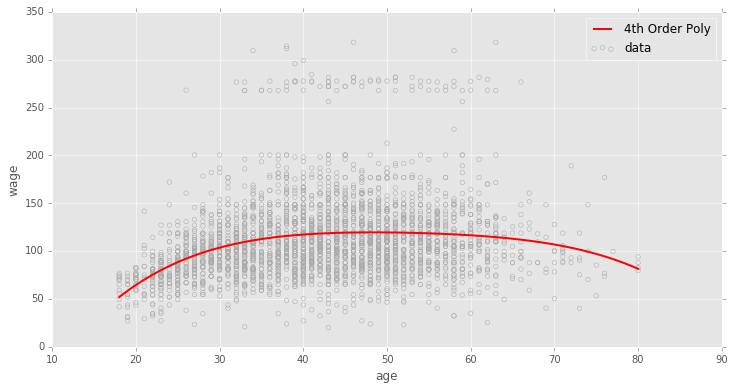

In [6]:
# Lastly, lets plot the data and the fit
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.scatter(Wages.age, Wages.wage, facecolors='none', edgecolors='darkgray', label='data')

# make a set of prediction wages from an age_grid
age_grid = np.linspace(Wages.age.min(), Wages.age.max(),1000).reshape(-1,1)
# Transform ages into a polynomial matrix
age_poly = PolynomialFeatures(4).fit_transform(age_grid)
# make predictions
predictions = linear_mod4.predict(age_poly)

# plot predictions
ax.plot(age_grid, predictions, lw=2, color='r', label='4th Order Poly')
ax.set_xlabel('age');
ax.set_ylabel('wage');
ax.legend(loc='best');

## Step Function of Age onto Wage

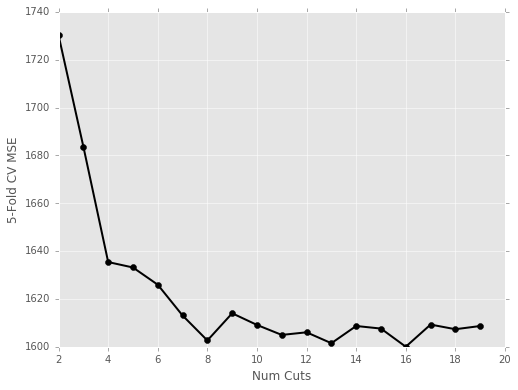

In [62]:
bns = np.arange(2,20)
scores = np.array([])

for cuts in bns:
    # return a dataframe of ages cut into bins
    cut_df = pd.cut(Wages.age, bins=cuts, right=False)
    # create a dummies dataframe using the cut value pairs as labels
    dummy_df = pd.get_dummies(data=cut_df)
    
    # build a linear model -- remember to drop first bin since bins are categoricals
    lm = LinearRegression(fit_intercept=True)
    steps = dummy_df.drop(dummy_df.columns[0], axis=1)
    scores = np.append(scores, -np.mean(cross_val_score(lm, X=steps, y=Wages.wage, scoring='mean_squared_error', 
                                                        cv=5)))
    
# Plot  
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(bns,scores, marker='o', lw=2,color='k');
ax.set_xlabel('Num Cuts');
ax.set_ylabel('5-Fold CV MSE');

So 8 cuts seems to be optimal. Lets make a plot of the data with an 8 cut step function.

In [67]:
# return a cut dataframe and make dummy variable of the cut regions
cut_df, bins = pd.cut(Wages.age, bins=8, retbins=True, right=False)
cut_df.head()
dummy_df = pd.get_dummies(cut_df)
dummy_df.head()

,"[18, 25.75)","[25.75, 33.5)","[33.5, 41.25)","[41.25, 49)","[49, 56.75)","[56.75, 64.5)","[64.5, 72.25)","[72.25, 80.062)"
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [68]:
# perform a linear regression- be sure to drop the first categorical column
lm = LinearRegression(fit_intercept=True)
steps = dummy_df.drop(dummy_df.columns[0], axis=1)
model = lm.fit(X=steps.values, y=Wages.wage)
print(lm.intercept_, lm.coef_)

76.281754721 [ 25.8333  40.2257  43.4577  40.6602  44.1024  28.9482  15.2242]


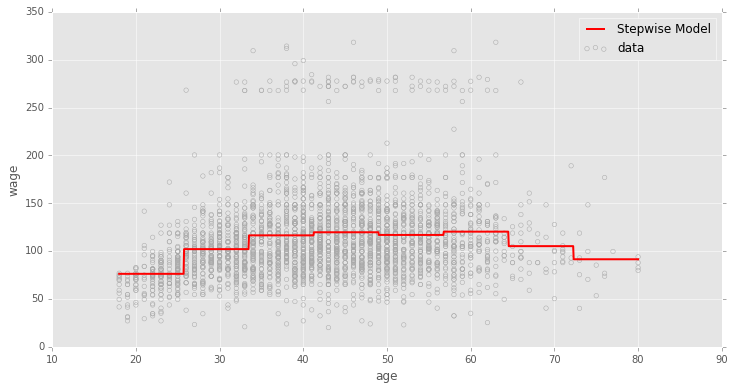

In [69]:
# Lastly, plot the data and the fit
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.scatter(Wages.age, Wages.wage, facecolors='none', edgecolors='darkgray', label='data')

# make a set of prediction wages from an age_grid
age_grid = np.linspace(Wages.age.min(), Wages.age.max(),1000).reshape(-1,1)
# place each age into a bin
age_bins = np.digitize(age_grid.ravel(), bins)
age_dummies = pd.get_dummies(age_bins).drop([1], axis=1)
# make predictions
predictions = lm.predict(age_dummies.values)

# plot predictions
ax.plot(age_grid, predictions, lw=2, color='r', label='Stepwise Model')
ax.set_xlabel('age');
ax.set_ylabel('wage');
ax.legend(loc='best');